In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install gym_super_mario_bros
#!pip install torch==0.3.1
from tensorboardX import SummaryWriter

In [2]:
reward_plot=[]

def plot(episode_count, episode_reward):
    clear_output(True)
    reward_plot.append(episode_reward)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episodes %s' % (episode_count))
    plt.plot(reward_plot)
    
    plt.xlabel('Episode(e)')
    plt.ylabel('Reward')
    
    plt.grid(True)
    
    plt.savefig("2_supermario_resolution_network.png")
    plt.show()


In [3]:
#import retro

import gym_super_mario_bros
import logging
import gym
import gym_super_mario_bros
import numpy as np
import sys
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv
import random
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F





In [4]:


movements = [
    ['NOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
]


from IPython.display import clear_output
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')





USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)






In [ ]:


from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
from collections import deque

print("done")


done


In [ ]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 5000000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [ ]:

_env = gym_super_mario_bros.make('SuperMarioBrosNoFrameskip-v3')
#_env = gym_super_mario_bros.SuperMarioBrosEnv(frames_per_step=1)
env = BinarySpaceToDiscreteSpaceEnv(_env, movements)
env    = wrap_pytorch(env)


In [ ]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 500000
replay_buffer = ReplayBuffer(5000000)

In [ ]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

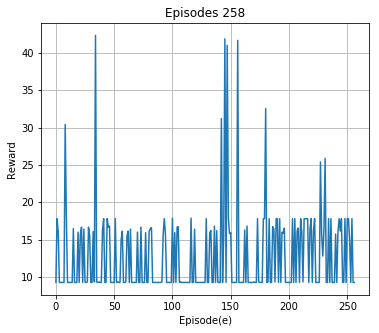

In [ ]:
num_frames = 3000000
batch_size = 32
gamma      = 0.99

writer = SummaryWriter()
losses = []
all_rewards = []
episode_reward = 0
episode_count = 1

state = env.reset()


for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    reward=reward/15
    state = next_state
    episode_reward += reward
    
   
    
        
    if info['life'] != 3:
            
            lif=True
            episode_count += 1
            #print(episode_count)
            state = env.reset()
            
            all_rewards.append(episode_reward)
            
            plot_episode_reward=episode_reward

            #plt.plot(episode_count,episode_reward)

            #plt.show()
            #print("count",episode_count,"ep",episode_reward)
            
            if episode_count % 1 == 0:
                plot(episode_count, plot_episode_reward)
                writer.add_scalar('data/reward', episode_reward, episode_count)
            episode_reward = 0
            
            env.reset()
            
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])            
            

        
#!tensorboard --logdir runs --port 6006   
#print(episode_reward, episode_count)